### Prepare and clean data

In [ ]:
import numpy as np 
import pandas as pd

import seaborn as sns 
import pylab as plt

import matplotlib.pyplot as plt
import os
import scipy.stats as stats

from scipy.stats import f_oneway, f
from statsmodels.stats.weightstats import ztest

import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tools.validation import array_like

from statsmodels.formula.api import ols
from pylab import rcParams
from pandas.plotting import lag_plot

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Ironhack/data_clean.csv')

In [ ]:
data.head()

,Unnamed: 0,anio,id_mes,mes,marca,tipo,segmento,origen,id_pais_origen,pais,uni_veh,anio_mes
0,0,2011,1,Jan,Acura,Camiones ligeros,SUV's,IMPORTADO,40,Canadá,24,2011-01-01
1,1,2011,1,Jan,Acura,Camiones ligeros,SUV's,IMPORTADO,66,Estados Unidos,21,2011-01-01
2,2,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,66,Estados Unidos,27,2011-01-01
3,3,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,66,Estados Unidos,5,2011-01-01
4,4,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,40,Canadá,27,2011-01-01


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50032 entries, 0 to 50031
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      50032 non-null  int64 
 1   anio            50032 non-null  int64 
 2   id_mes          50032 non-null  int64 
 3   mes             50032 non-null  object
 4   marca           50032 non-null  object
 5   tipo            50032 non-null  object
 6   segmento        50032 non-null  object
 7   origen          50032 non-null  object
 8   id_pais_origen  50032 non-null  int64 
 9   pais            50032 non-null  object
 10  uni_veh         50032 non-null  int64 
 11  anio_mes        50032 non-null  object
dtypes: int64(5), object(7)
memory usage: 4.6+ MB


In [ ]:
data.drop(columns='Unnamed: 0')

,anio,id_mes,mes,marca,tipo,segmento,origen,id_pais_origen,pais,uni_veh,anio_mes
0,2011,1,Jan,Acura,Camiones ligeros,SUV's,IMPORTADO,40,Canadá,24,2011-01-01
1,2011,1,Jan,Acura,Camiones ligeros,SUV's,IMPORTADO,66,Estados Unidos,21,2011-01-01
2,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,66,Estados Unidos,27,2011-01-01
3,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,66,Estados Unidos,5,2011-01-01
4,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,40,Canadá,27,2011-01-01
...,...,...,...,...,...,...,...,...,...,...,...
50027,2021,12,Dec,Volkswagen,Camiones ligeros,Pick Ups,IMPORTADO,177,Polonia,1,2021-12-01
50028,2021,12,Dec,Volvo,Automóviles,De Lujo,IMPORTADO,66,Estados Unidos,20,2021-12-01
50029,2021,12,Dec,Volvo,Automóviles,De Lujo,IMPORTADO,23,Bélgica,87,2021-12-01
50030,2021,12,Dec,Volvo,Camiones ligeros,SUV's,IMPORTADO,209,Suecia,141,2021-12-01


In [ ]:
df_pivot = data.groupby('anio_mes').agg({'uni_veh':'sum'})
df_pivot

,uni_veh
anio_mes,
2011-01-01,68767
2011-02-01,66990
2011-03-01,75125
2011-04-01,65246
2011-05-01,68634
...,...
2021-08-01,78235
2021-09-01,76930
2021-10-01,76640


### Check and remove stationarity

In [ ]:
def viewing_stationarity(df, window=5):
    """
    Esta función genera un plot para una serie de tiempo
    con su media móvil y su desviación estándar.
    """

    rolmean = df.rolling(window=window).mean()
    rolstd = df.rolling(window=window).std()

    fig = plt.figure(figsize=(10, 5))
    time_series = plt.plot(df, color='blue', label='original')
    mean = plt.plot(rolmean, color='red', label='media móvil')
    std = plt.plot(rolstd, color='green', label='desviación estándar móvil')
    plt.legend(loc='best')
    plt.show();

In [ ]:
class Stationary:
    def __init__(self, significance=0.05):
        self.significance_level = significance
        self.pvalue = None
        self.is_stationary = None

    def ADF(self, values):
        result = adfuller(values, autolag='AIC')

        format_results = pd.Series(result[:4], 
                                    index=['Statistic', 'P-value',
                                        'Num of Lags', 'Observations'])
        for k,v in result[4].items():
            format_results[f'Critical Value {k}'] = v

        return format_results

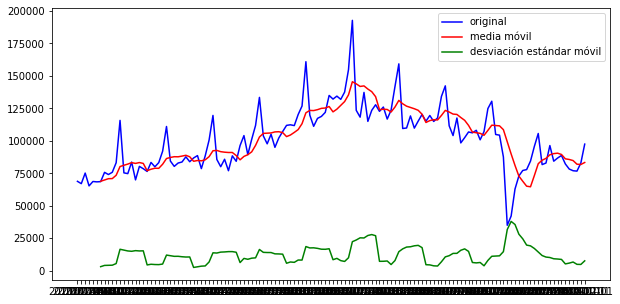

Statistic              -1.491928
P-value                 0.537501
Num of Lags            12.000000
Observations          119.000000
Critical Value 1%      -3.486535
Critical Value 5%      -2.886151
Critical Value 10%     -2.579896
dtype: float64

In [ ]:
viewing_stationarity(df_pivot, window=7)
adf_test = Stationary()
adf_test.ADF(df_pivot['uni_veh'].values).round(6)

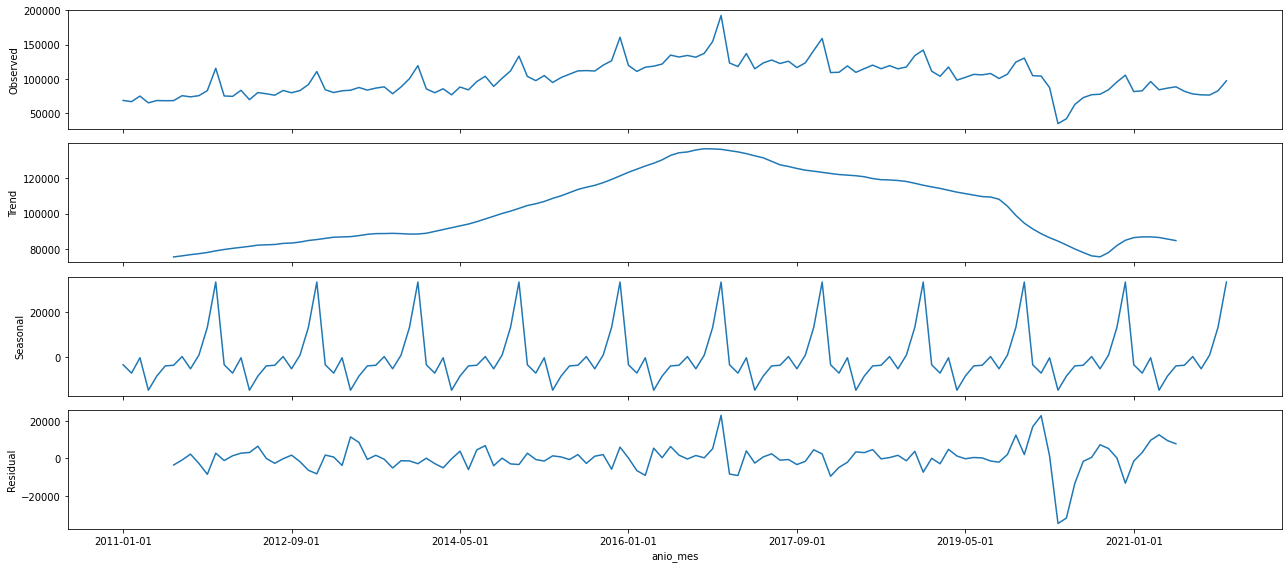

In [ ]:
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df_pivot, freq=12)
fig = decomposition.plot()
plt.show()

### Run Prophet

In [ ]:
len(data.anio_mes)*.80

40025.600000000006

In [ ]:
split_date = data.anio_mes.loc[40026]
split_date

'2020-02-01'

In [ ]:
train = df_pivot.loc[df_pivot.index <= split_date].copy()
train = train.reset_index().rename(columns={'anio_mes': 'ds', 'uni_veh': 'y'})
train


,ds,y
0,2011-01-01,68767
1,2011-02-01,66990
2,2011-03-01,75125
3,2011-04-01,65246
4,2011-05-01,68634
...,...,...
105,2019-10-01,107110
106,2019-11-01,124804
107,2019-12-01,130460
108,2020-01-01,104852


In [ ]:
test = df_pivot.loc[df_pivot.index > split_date].copy()
test = test.reset_index().rename(columns={'anio_mes':'ds', 'uni_veh':'y'})
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      22 non-null     object
 1   y       22 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 480.0+ bytes


In [ ]:
%%time

modelo = Prophet().fit(train)
prediccion = modelo.predict(test)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2.46 s, sys: 173 ms, total: 2.63 s
Wall time: 2.93 s


In [ ]:
test_fetch = pd.DataFrame(['2020-02-01'], columns=['ds'])
test_fetch

,ds
0,2020-02-01


In [ ]:
predict_date = modelo.predict(test_fetch)
predict_date

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-01,105748.437524,91932.598038,103620.489391,105748.437524,105748.437524,-7941.911089,-7941.911089,-7941.911089,-7941.911089,-7941.911089,-7941.911089,0.0,0.0,0.0,97806.526435


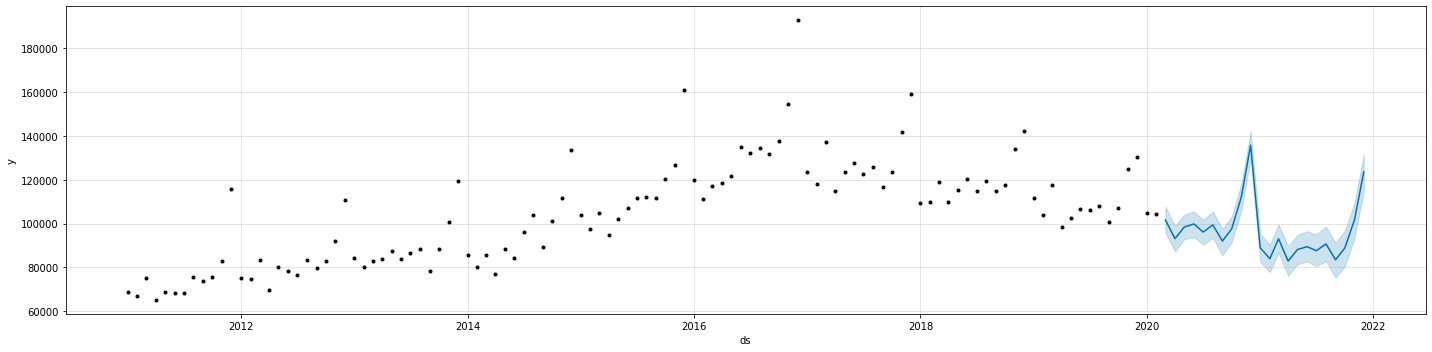

In [ ]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(20)
f = modelo.plot(prediccion, ax=ax)

In [ ]:
test['ds'] = test['ds'].astype('datetime64[ns]')

In [ ]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(20)
ax.scatter(test.set_index('ds'), test.y, color='r')
f = modelo.plot(prediccion, ax=ax)
#prediccion.plot()

ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fe2f6bfb170> (for post_execute):


ValueError: ignored

ValueError: ignored

In [ ]:
mse(test.y, prediccion.yhat) ** 0.5

23588.675720151707

In [ ]:
mean_absolute_percentage_error(test.y, prediccion.yhat)

0.2871092530533624

In [ ]:
prediccion.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-01,105007.320906,96001.029386,107780.237567,105007.167986,105007.320906,-3310.666463,-3310.666463,-3310.666463,-3310.666463,-3310.666463,-3310.666463,0.0,0.0,0.0,101696.654443
1,2020-04-01,104215.092796,87345.915180,98883.503490,104153.727246,104275.952092,-11046.912567,-11046.912567,-11046.912567,-11046.912567,-11046.912567,-11046.912567,0.0,0.0,0.0,93168.180229
2,2020-05-01,103448.420432,92892.453626,104036.247389,103298.075929,103617.059695,-5018.855755,-5018.855755,-5018.855755,-5018.855755,-5018.855755,-5018.855755,0.0,0.0,0.0,98429.564677
3,2020-06-01,102656.192323,93946.853442,105614.246451,102331.928098,102973.122461,-2784.750109,-2784.750109,-2784.750109,-2784.750109,-2784.750109,-2784.750109,0.0,0.0,0.0,99871.442214
4,2020-07-01,101889.519959,90417.618097,101696.733949,101383.504863,102365.414847,-5731.784461,-5731.784461,-5731.784461,-5731.784461,-5731.784461,-5731.784461,0.0,0.0,0.0,96157.735498


In [ ]:
future = modelo.make_future_dataframe(periods=12)
forecast = modelo.predict(future)

In [ ]:
forecast.tail(30)

### Run full dataset on Prophet

In [ ]:
df_for_model = df_pivot.reset_index().rename(columns={'anio_mes':'ds', 'uni_veh':'y'})
df_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      132 non-null    object
 1   y       132 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [ ]:
df_for_model['ds'] = df_for_model['ds'].astype('datetime64[ns]')
df_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      132 non-null    datetime64[ns]
 1   y       132 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.2 KB


In [ ]:
modelo = Prophet().fit(df_for_model)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = modelo.make_future_dataframe(periods=12)
future.tail()

,ds
139,2021-12-09
140,2021-12-10
141,2021-12-11
142,2021-12-12
143,2021-12-13


In [ ]:
forecast = modelo.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
139,2021-12-09,111436.134590,99189.193194,123355.326310
140,2021-12-10,111680.945107,99633.644485,124078.805721
141,2021-12-11,111773.511237,99759.939134,123811.890375
142,2021-12-12,111695.763653,99219.843871,123523.317402
143,2021-12-13,111430.916067,99304.412161,122287.540900


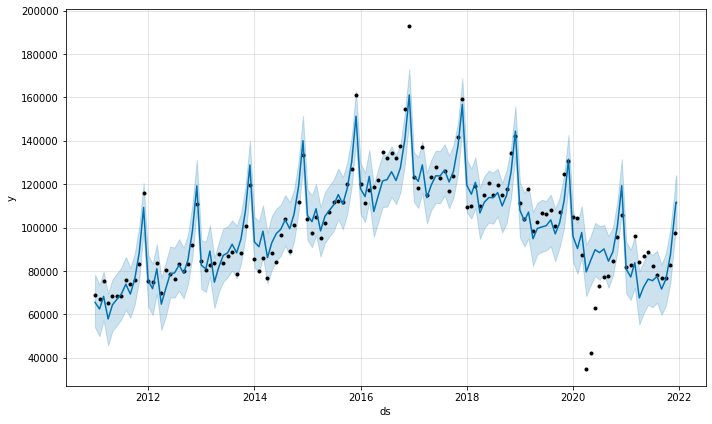

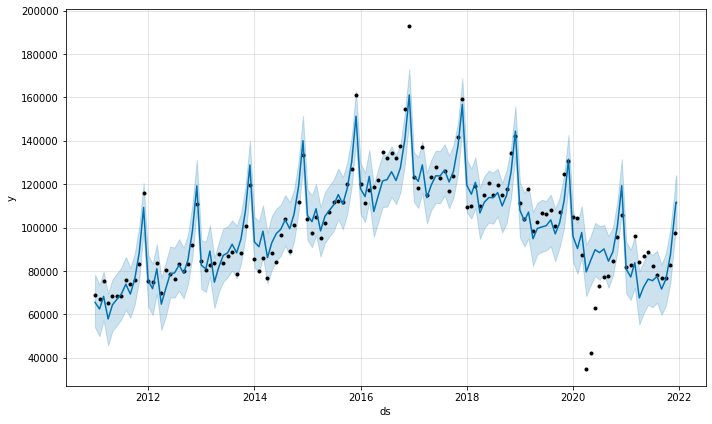

In [ ]:
modelo.plot(forecast)

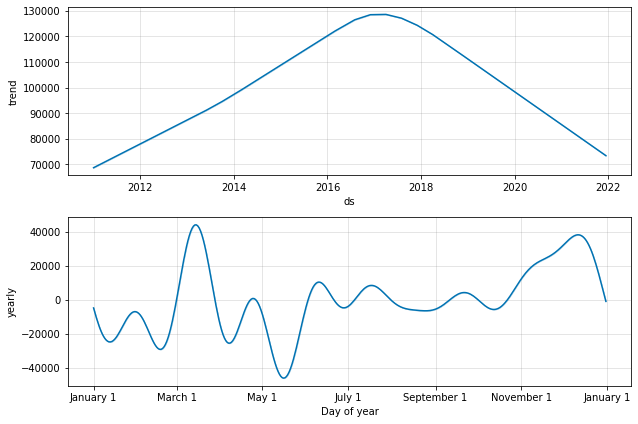

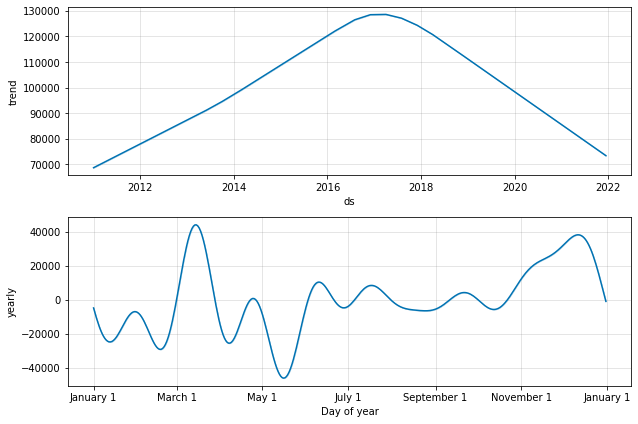

In [ ]:
modelo.plot_components(forecast)

In [ ]:
mse(df_for_model['y'], forecast.yhat)

### Prophet, full Model

In [ ]:
test = df_for_model.loc[df_pivot.index > split_date].copy()
#test = test.reset_index().rename(columns={'anio_mes':'ds', 'uni_veh':'y'})
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 110 to 131
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      22 non-null     datetime64[ns]
 1   y       22 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 528.0 bytes


In [ ]:
modelo = Prophet().fit(df_for_model)
prediccion = modelo.predict(test)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


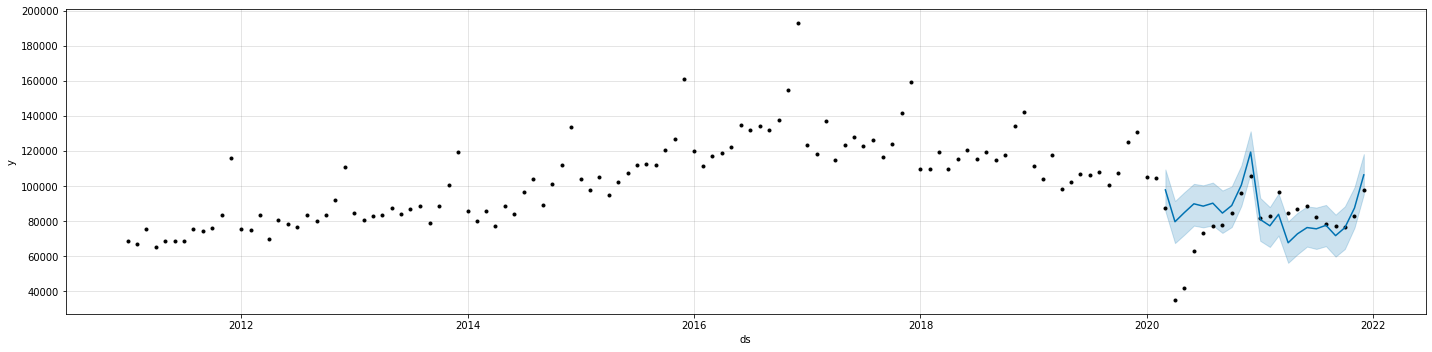

In [ ]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(20)
f = modelo.plot(prediccion, ax=ax)

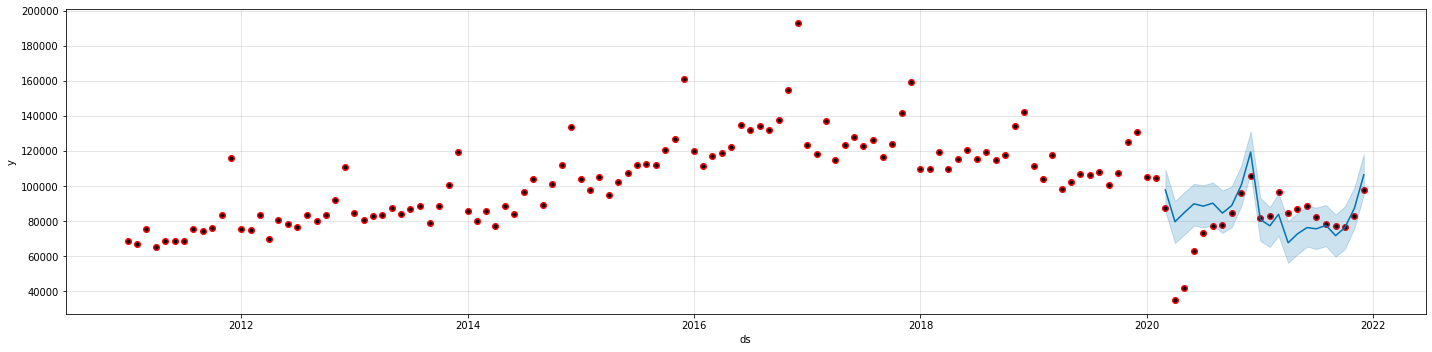

In [ ]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(20)
ax.scatter(df_for_model.ds, df_for_model.y, color='r')
f = modelo.plot(prediccion, ax=ax)

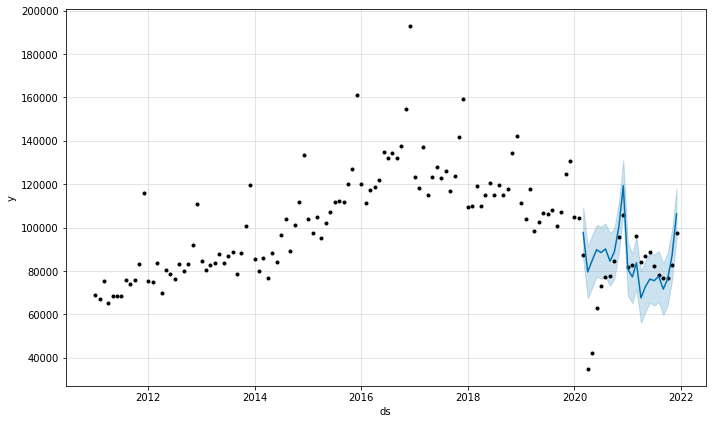

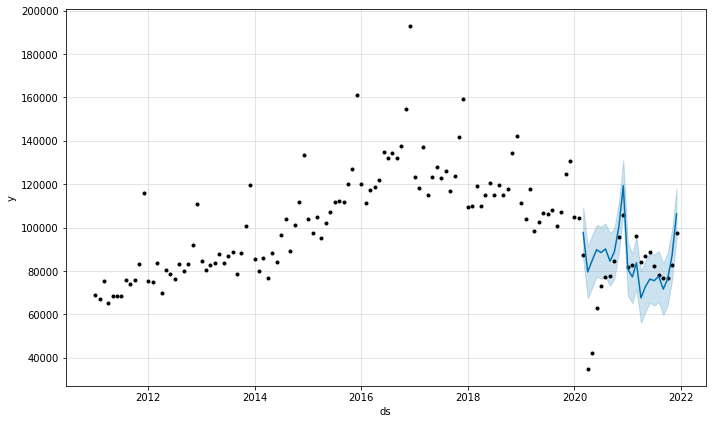

In [ ]:
modelo.plot(prediccion)

In [ ]:
mse(test.y, prediccion.yhat) ** 0.5

16950.23932824668

In [ ]:
mean_absolute_percentage_error(test.y, prediccion.yhat)*100

20.715687726180633